# Non Linear Manifold Identification

The critical idea of dimensionality reduction is that most datasets are represented with a higher number of variables than strictly necessary. That is to say, data points lie on data manifolds that have a low *intrinsic* dimension, and can thus be represented using a low number of features. The issue is that these low-dimensional representations are not known *a-priori* and often need to be extracted from data. This makes dimensionality reduction a very efficient pre-processing step to most machine learning algorithm as it makes for much better organised and compact datasets, simplifying learning problems and reducing computational costs.
</br>
</br>
</br>
This notebook contains an example of some methods for non linear manifold analysis :

* K means
* Diffusion Maps
* Locally Linear Embeddings
* Isomaps
* Neural AutoEncoder
* PCA (linear) for comparison
</br>
</br>
</br>

Note that the methods presented here are better implemented  in most ML packages, the goal here is to give an idea of the way each method works.

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
import scipy
from scipy.linalg import eigh
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
matplotlib.rcParams.update({'font.size': 20})
seed = 1337 # Highly optimised seed for isomap computation speed :)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

A simple two dimensional manifold embedded in a 3-dimensional space is chosen to illustrate the advantages and drawbacks of the presented dimensionality reduction methods.

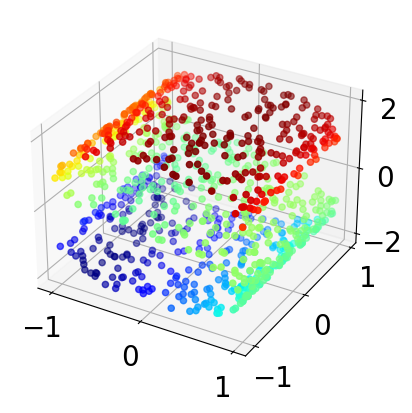

In [2]:
n_samples = 1000
X, _ = ds.make_s_curve(n_samples=n_samples, noise=0)
X = X-X.mean(0)
anchor = np.amin(X,0)
dx = X.shape[1]
coloring = ((X[:,0]-anchor[0])**2 + (X[:,2]-anchor[2])**2)**0.5
coloring = coloring-coloring.min()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)

## K means

Not a manifold identification method *per-se*, the K means method construct clusters which separates the data manifold into groups of spatially close points.
</br>
</br>
</br>
***Algorithm Idea:*** Iteratively assign each point to the closest cluster and move the cluster to the barycenter of the assigned points until convergence.

/tmp/ipykernel_13925/1697488287.py:17: RuntimeWarning: Mean of empty slice.
  barycenters = X[indexes==i].mean(axis=0)
/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


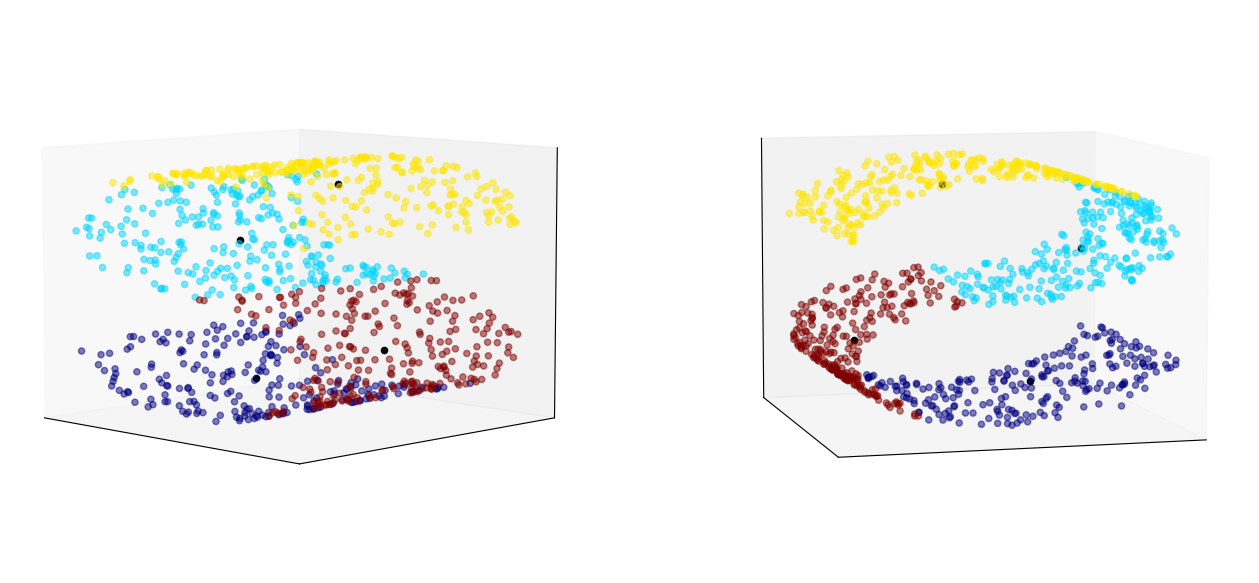

In [3]:
def compute_cluster_indexes(X,centers):
    # computes closest cluster for each point
    distances = [(X-c)**2 for c in centers] # distance to clusters
    distances = np.stack([d.sum(1) for d in distances]).T
    indexes = np.argmin(distances,axis=1) # index of min distance
    return indexes

# Random clusters
n_clusters = 4
centers = 10*np.random.randn(n_clusters*dx).reshape(n_clusters,dx)
diff = np.inf
while diff > 1e-4: 
    indexes = compute_cluster_indexes(X,centers)
    diff = 0
    for i in range(n_clusters):
        # Compute the barycenter
        barycenters = X[indexes==i].mean(axis=0)
        if np.isnan(barycenters).any():
            # New random cluster if barycenter is nan
            centers[i] = np.random.randn(dx)
            diff = np.inf
            pass
        else:
            # Move cluster to barycenter
            diff = max((barycenters-centers[i]).max(),diff)
            centers[i] = barycenters
indexes = compute_cluster_indexes(X,centers)

# Plotting
def plot_one(X,indexes,centers):
    ax.scatter(*X.T,c=indexes,alpha=0.5,cmap=plt.cm.jet)
    for c in centers:
        ax.scatter(*c,color='black')
    ax.set_xticks([]);ax.set_yticks([]);ax.set_zticks([])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d', elev=7, azim=-45)
plot_one(X,indexes,centers)
ax = fig.add_subplot(122,projection='3d', elev=7, azim=75)
plot_one(X,indexes,centers)


## PCA

Principal Component Analysis is the most common dimensionality reduction algorithm, however, it's efficacy is limited in the case of strongly non-linear manifolds, as is the case here.
</br>
</br>
</br>
***Algorithm Idea:*** Identify linear correlations between features through the eigendecomposition of the data covariance matrix (equivalent to the SVD of the data matrix) to obtain the most expressive directions in the feature space.

Text(0.5, 0.92, 'Reconstruction')

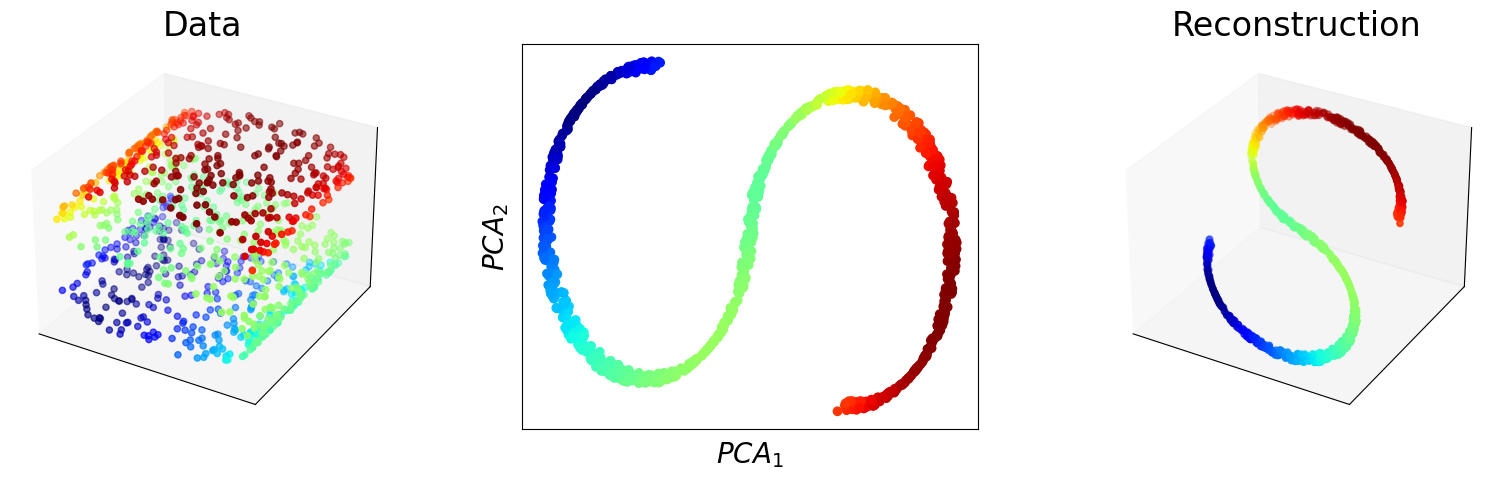

In [4]:
# Centering
mean_field = X.mean(0).reshape(-1,1)
# SVD of the data
U,s,V = np.linalg.svd(X.T-mean_field)
pca = U[:,:2].T.dot(X.T)
# PCA allows for the simple reconstruction of the data
reconstruction = U[:,:2].dot(pca) + mean_field

# Plotting
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
plt.title('Data')

ax = fig.add_subplot(1,3,2)
ax.scatter(*pca,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([])
plt.xlabel(r'$PCA_1$')
plt.ylabel(r'$PCA_2$')

ax = fig.add_subplot(1,3,3,projection='3d')
ax.scatter(*reconstruction,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
plt.title('Reconstruction')

## Diffusion maps

Diffusion maps are a nonlinear reduction methods that constructs a low dimensional embedding based on the euclidean distance between data points.  
</br>
</br>
</br>
***Algorithm Idea:*** Construct a Markov transition matrix as the probability of one point to *jump* to another based on their euclidean distance. The eigendecomposition of the transition probability matrix yields a suitable embedding of the data
</br>
</br>
</br>
[Tutorial](https://inside.mines.edu/~whereman/talks/delaPorte-Herbst-Hereman-vanderWalt-DiffusionMaps-PRASA2008.pdf)

[Kaggle Example](https://www.kaggle.com/code/rahulrajpl/diffusion-map-for-manifold-learning)

Text(0, 0.5, '$DM_2$')

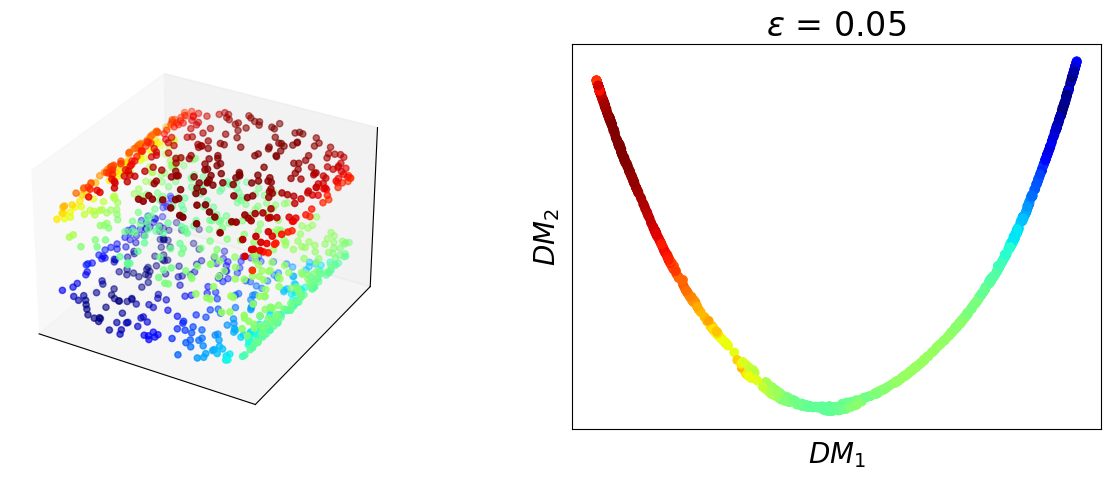

In [5]:
# Distances
dists = euclidean_distances(X,X)
def get_coords(eps):
    # Gaussian Kernel
    K = np.exp(-dists**2/eps)
    # Probability (Kernel normalisation)
    r = K.sum(0)
    D = np.diag(1/r)
    P = np.matmul(D, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))
    # Eigendecomposition
    eigvals, V = eigh(P_prime)
    # Bottom eigenvectors of the normalised kernel yield the low dimensional embedding
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    V = V[:,idx]

    coords = np.matmul(D_left,V)[:,1:3]
    return coords

diffmap = get_coords(0.05)

# Plotting
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.title(r'$\epsilon$ = {}'.format(0.05))
plt.scatter(*diffmap.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([])
plt.xlabel(r'$DM_1$')
plt.ylabel(r'$DM_2$')

## Locally Linear Embedding

Locally Linear Embeddings are a nonlinear reduction method that leverages the local *smoothness* of the attractor to construct a low dimensional embedding of the data. The idea can be seen as cutting out small patches of the attractor to arrange them in a lower dimensional space, similar to the way we draw maps of the world in two dimensions.
</br>
</br>
</br>
***Algorithm Idea:*** Express each data point as a linear combination of its neighbors. The weights obtained represent the local relationships between points on the attractor. Low dimensional coordinates are computed so that these relationships are conserved in the low dimensional embedding of the data.
</br>
</br>
</br>
[Tutorial](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf)

[Kaggle example](https://www.kaggle.com/code/ukveteran/locally-linear-embedding-swiss-roll-data-jma/notebook)

Text(0, 0.5, '$LLE_2$')

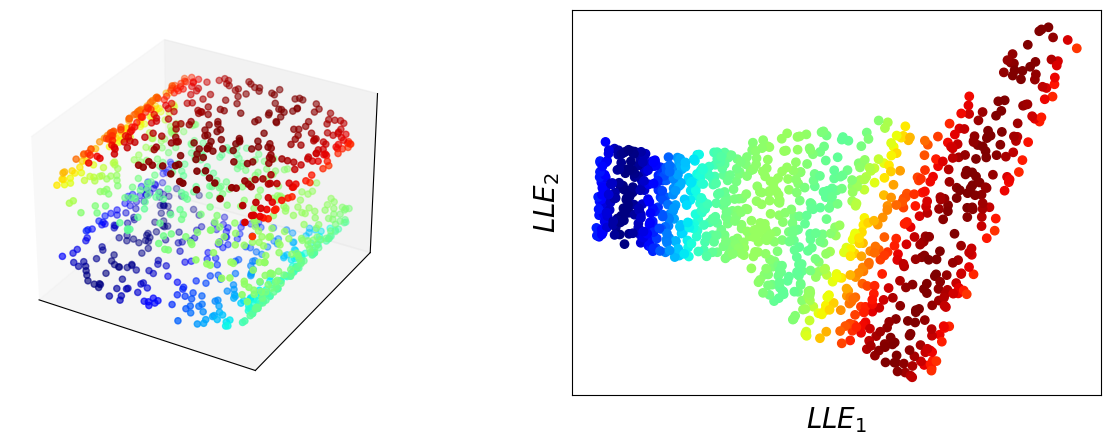

In [6]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Local spaces construction
matrices = []
for n in neighbours_mat:
    matrices.append(np.stack([X[i] for i in n]))
matrices=np.stack(matrices)
# Local correlation and weights computation
stacked_X = np.stack([X])
stacked_X = np.moveaxis(stacked_X,0,1)
diff = stacked_X-matrices
W = np.zeros((X.shape[0],X.shape[0]))
for i,(n,dif) in enumerate(zip(neighbours_mat,diff)):
    C = np.matmul(dif,dif.T)
    C = C+np.identity(n_neighbors)*1e-4*np.trace(C)
    c_inv = np.linalg.inv(C)
    W[i][n] = c_inv.sum(1)/c_inv.sum()
    
# Eigenvectors computation / Leading eigenvectors are the low dimensional coordinates
M = np.matmul((np.eye(X.shape[0])-W).T,(np.eye(X.shape[0])-W))
eigvals, eigvecs = eigh(M)
index = np.argsort(eigvals)
lle = eigvecs[:,index[1:3]]*np.sqrt(X.shape[0])

# Plotting
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.scatter(*lle.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$LLE_1$'); plt.ylabel(r'$LLE_2$')

## Isomap

Isomaps are based on Multi Dimensional Scaling, a non linear dimensionality reduction method that strives to conserve distances between points in the low dimensional embedding. The specificity is that isomaps conserve the geodesic distance along the attractor, rather than the euclidean distance.
</br>
</br>
</br>
***Algorithm Idea:*** Compute the geodesic distance on the attractor using the nearest neighbor graph and a shortest path algorithm, then minimise the embedding stress, that is the difference between the computed geodesic distances and the euclidean distances in the embedded space.

/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, '$ISO_2$')

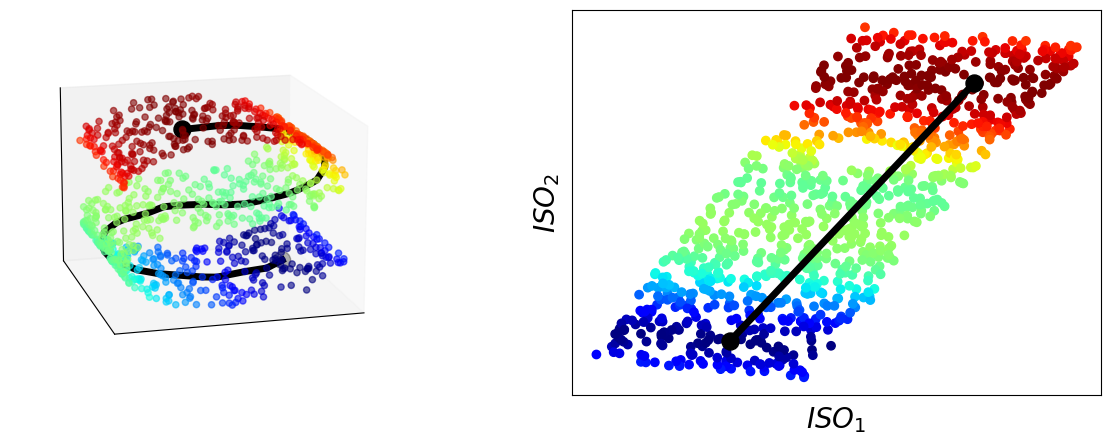

In [7]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Geodesic distance
graph = np.zeros((X.shape[0],X.shape[0]))
for i,(dist,neighb) in enumerate(zip(distance_mat, neighbours_mat)):
    graph[i][neighb] = dist

distances, pred = scipy.sparse.csgraph.dijkstra(graph,return_predecessors=True,directed=False)
#Stress optimisation (MDS)
isomap,_ = manifold.smacof(distances)

# Constructing geodesic path for plot
high, low = np.argmax(coloring), np.argmin(coloring)
points_hi = [high]
points_lo = [low]
while points_hi[-1] != points_lo[-1]:
    lo, hi = points_lo[-1], points_hi[-1]
    points_hi.append(pred[lo,hi])
    points_lo.append(pred[hi,lo])
path = points_hi+points_lo[::-1]

# Plotting
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d',elev=15, azim=75)
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
xp,yp,zp = X[path,0], X[path,1], X[path,2]
ax.plot(xp,yp,zp,lw=5,color='black')
ax.scatter(X[[high,low],0],X[[high,low],1],X[[high,low],2],s=150,color='black')
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.scatter(*isomap.T,c=coloring,cmap=plt.cm.jet)
plt.plot(*isomap[[high,low]].T,lw=5,color='black')
ax.scatter(isomap[[high,low],0],isomap[[high,low],1],s=150,color='black')
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$ISO_1$'); plt.ylabel(r'$ISO_2$')

## Neural Network

Neural Networks are universal function approximators. They can be used to learn the map from the data to a low dimensional embedding space. They also allow for simple reconstruction from the embedded space.
</br>
</br>
</br>
***Algorithm Idea:*** Minimise the expected reconstruction error after passing the data points through the encoder and decoder parts of the network. The embedding coordinates correspond to the output of the encoder network.


100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


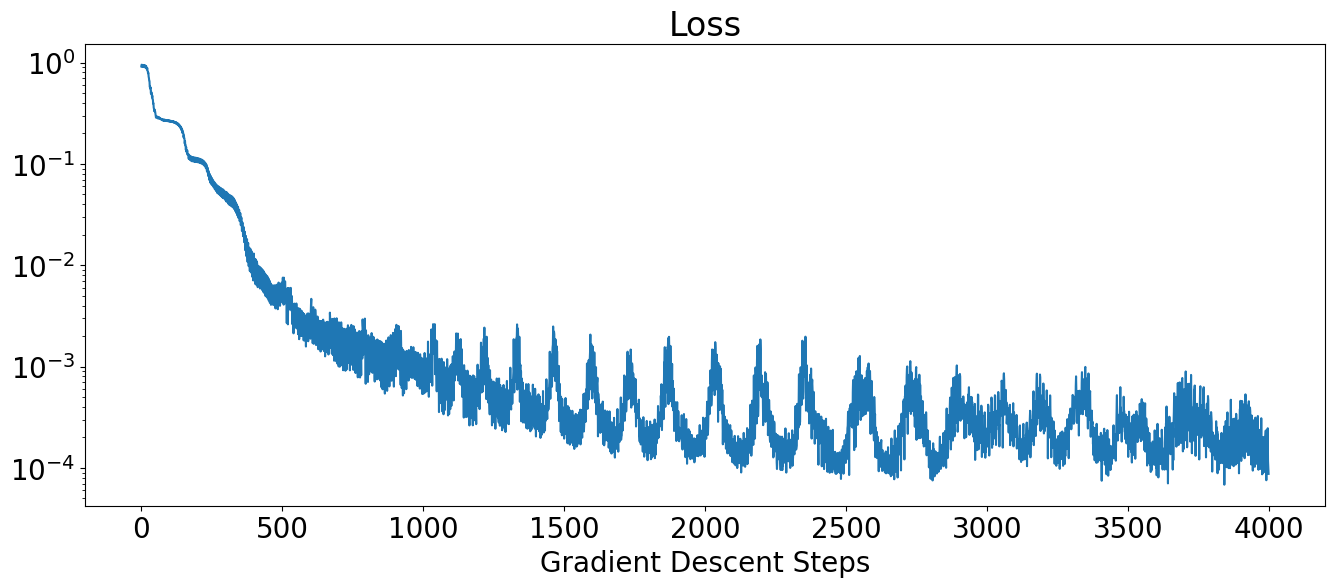

In [8]:
# GPU availability
if torch.cuda.is_available(): dev=torch.device('cuda')
else: dev = torch.device('cpu')
    
X_torch = torch.tensor(X,dtype=torch.float).to(dev)
# Model Definition
dz = 2 # embedding dimension
width = 64; act = nn.ReLU()
Enc = nn.Sequential(nn.Linear(X.shape[-1],width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,dz)).to(dev) # Encoder
Dec = nn.Sequential(nn.Linear(dz,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,X.shape[-1])).to(dev) # Decoder
opt = torch.optim.Adam(list(Enc.parameters())+list(Dec.parameters()),lr=1e-3) # Optimizer
loader = DataLoader(TensorDataset(X_torch),batch_size=256) # Data loader, in this case we map X to X
lossfunc = nn.MSELoss() # Simple mean squared error loss
losses = []
for j in tqdm(range(1000)):
    for i, (x,) in enumerate(loader):
        opt.zero_grad()
        loss = lossfunc(Dec(Enc(x)),x) # Reconstruction error
        loss.backward() # Gradient computation
        opt.step() # Descent step
        losses.append(loss.item())
autoenc = Enc(X_torch) # Final embedding
decoded = Dec(autoenc).detach().cpu().numpy() # Reconstruction
autoenc = autoenc.detach().cpu().numpy()

# Intermediate states for disentanglement plot
intermediates = [X_torch.detach().cpu().numpy().T]
intermediate = X_torch
for i in range(int(len(Enc)/2)):
    intermediate = Enc[2*i+1](Enc[i*2](intermediate))
    interm = intermediate.detach().cpu().numpy().T
    interm = interm - interm.mean(1).reshape(-1,1)
    U,s,V = np.linalg.svd(interm)
    projected = U[:,:3].T.dot(interm)
    intermediates.append(projected)
intermediates.append(Enc(X_torch).detach().cpu().numpy().T)

# Plotting
plt.figure(figsize=(16,6))
plt.title('Loss'); plt.xlabel('Gradient Descent Steps')
plt.semilogy(losses)

Text(0.5, 1.0, '$\\Phi(x)$')

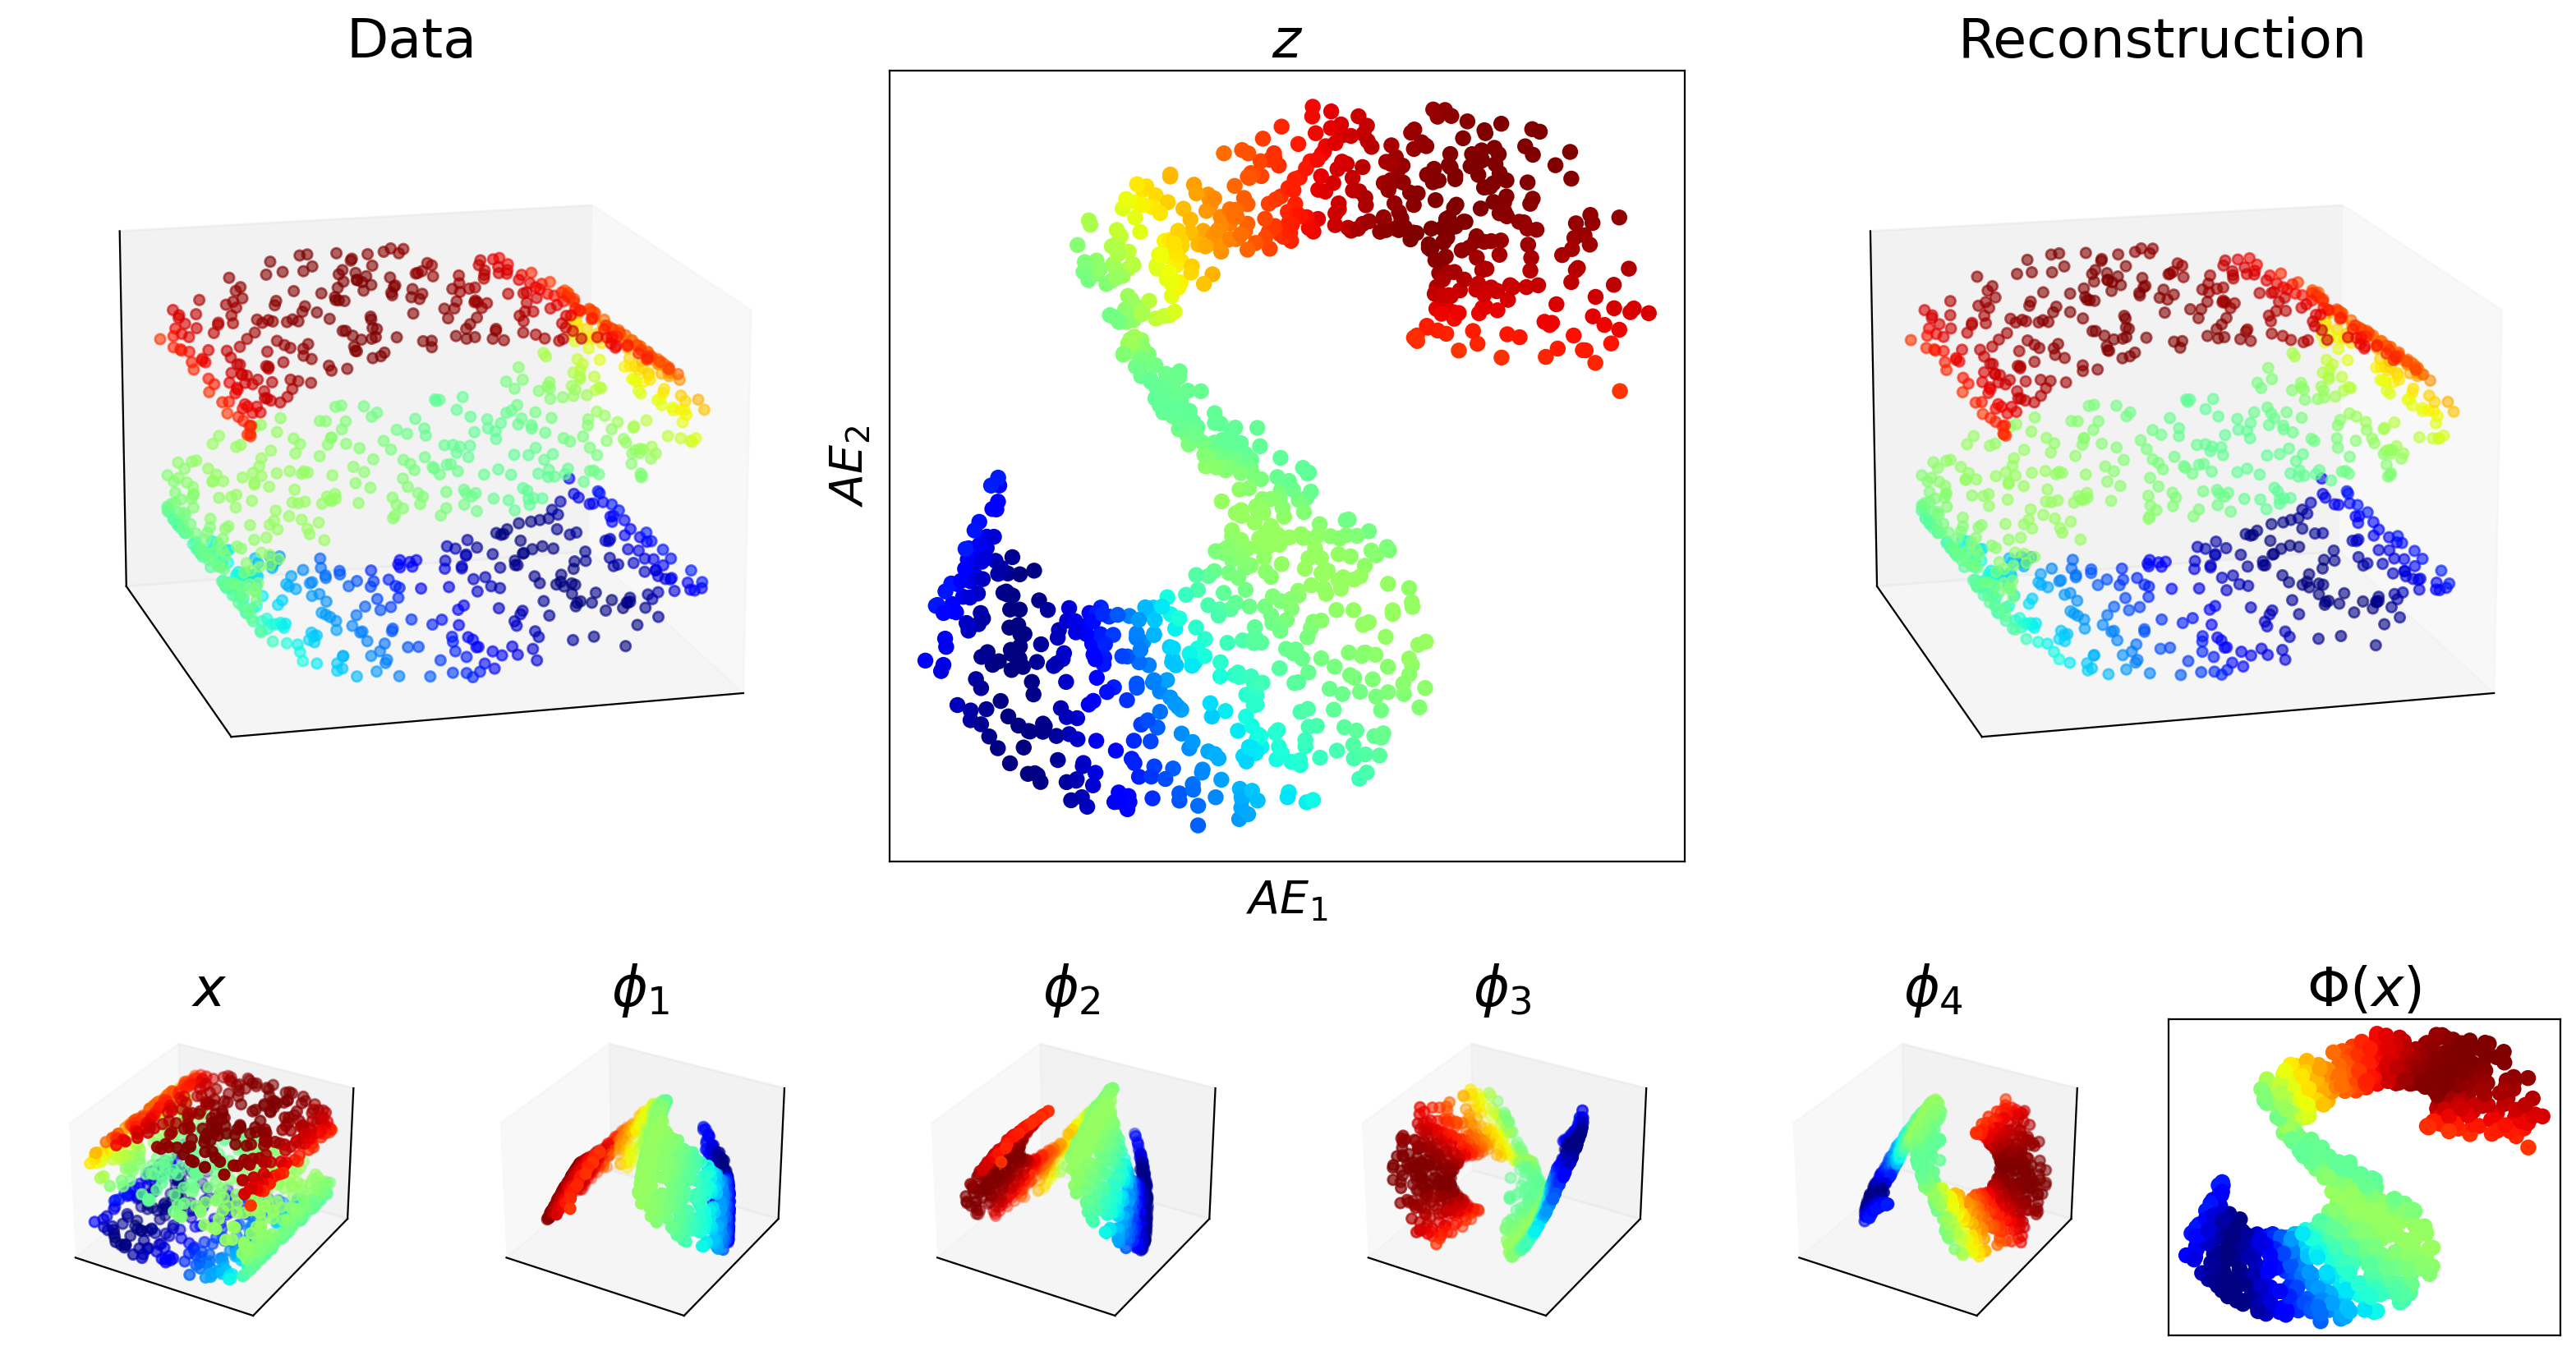

In [9]:
height_ratio = 2
sub_wspace, sub_hspace = 0.1, 0.7

fig = plt.figure(figsize=(20,10),dpi=200)
gs0 = gridspec.GridSpec(height_ratio+1,1,figure=fig,hspace=0.5)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[:height_ratio,:],
                                    wspace=sub_wspace,hspace=sub_hspace)

ax = plt.subplot(gs00[0, 0],projection='3d',elev=15, azim=75)
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
ax.set_title('Data')

ax = plt.subplot(gs00[0, 1])
plt.scatter(*autoenc.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$AE_1$'); plt.ylabel(r'$AE_2$')
ax.set_title(r'$z$')

ax = plt.subplot(gs00[0, 2],projection='3d',elev=15, azim=75)
ax.scatter(*decoded.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
ax.set_title('Reconstruction')


n_plots = len(intermediates)
gs10 = gridspec.GridSpecFromSubplotSpec(1, n_plots, subplot_spec=gs0[height_ratio:,:],
                                    wspace=sub_wspace,hspace=sub_hspace)

for i in range(n_plots-1):
    ax = plt.subplot(gs10[0,i],projection='3d')
    ax.scatter(*intermediates[i],c=coloring,cmap=plt.cm.jet)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    if i == 0:
        ax.set_title(r'$x$')
    else: ax.set_title(r'$\phi_{:}$'.format(i))
        
ax = plt.subplot(gs10[0,-1])
ax.scatter(*intermediates[-1],c=coloring,cmap=plt.cm.jet)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title(r'$\Phi(x)$')
#plt.savefig('../ManuscriptVisuals/AE_performance.png',dpi=200,bbox_inches='tight')

## Side by Side

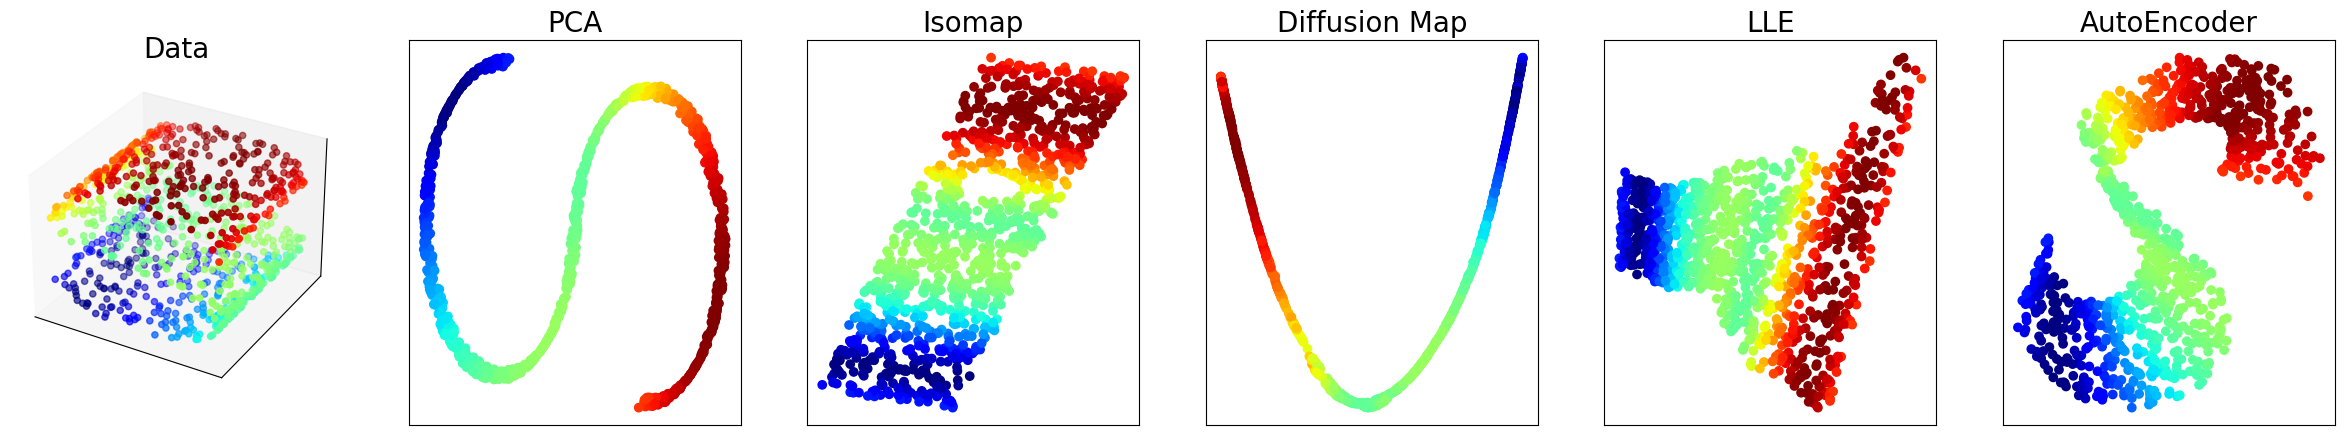

In [10]:
fs = 20

arrays = [pca.T,isomap,diffmap,lle,autoenc]
titles = ['PCA','Isomap','Diffusion Map','LLE','AutoEncoder']

fig = plt.figure(figsize=(5*(1+len(arrays)),5))
ax = fig.add_subplot(1,len(arrays)+1,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
plt.title('Data',fontsize=fs)
for i,(arr,titl) in enumerate(zip(arrays,titles)):
    ax = fig.add_subplot(1,len(arrays)+1,i+2)
    plt.title(titl,fontsize=fs)
    ax.scatter(*arr.T,c=coloring,cmap=plt.cm.jet)
    plt.xticks([]); plt.yticks([])

## Creating Readme

In [11]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [12]:
os.system('rm manifold_identification_files/*')
os.system('jupyter nbconvert --to markdown manifold_identification.ipynb')
os.system('mv manifold_identification.md README.md')
os.system('git add manifold_identification_files/')


[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook manifold_identification.ipynb to markdown
[NbConvertApp] Support files will be in manifold_identification_files/
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Writing 17969 bytes to manifold_identification.md


0